**Logistic Regression**

This notebook contains hyper-tuning Logistic Regression.

In [10]:
import pandas as pd
import mlutils
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from ipywidgets import widgets

# column names
feature_col = "features" # feature vector
value_col = "foldClass" # fold class to be predicted

# Read data
df = pd.read_json("./intermediate_data/features.json")

# Split data into train, and test data. 
# train: 90% test: 10%
train, test = train_test_split(df, test_size=0.1, random_state=13, stratify=df[value_col])
print("Training set size:", train.shape[0], "\n")
print(train[value_col].value_counts())
print()
print("Test set size:", test.shape[0], "\n")
print(test[value_col].value_counts())

Training set size: 4833 

alpha         2529
alpha+beta    1519
beta           785
Name: foldClass, dtype: int64

Test set size: 537 

alpha         281
alpha+beta    169
beta           87
Name: foldClass, dtype: int64


Train Logistic Regression and predicts the result.

Classification metrics:

             precision    recall  f1-score   support

      alpha       0.86      0.79      0.83       281
 alpha+beta       0.64      0.63      0.64       169
       beta       0.61      0.78      0.68        87

avg / total       0.75      0.74      0.74       537



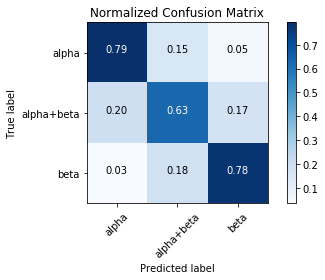

In [12]:
classifier = LogisticRegression(class_weight='balanced', random_state=13, solver='lbfgs', multi_class='ovr', max_iter=500)
classifier.fit(train[feature_col].tolist(), train[value_col])
predicted = classifier.predict(test[feature_col].tolist())
expected = test[value_col]

print("Classification metrics:\n")
print(metrics.classification_report(expected, predicted))

cm = metrics.confusion_matrix(expected, predicted)
mlutils.plot_confusion_matrix(cm, classifier.classes_, normalize=True, title='Normalized Confusion Matrix')

In [19]:
train_score = classifier.score(train[feature_col].tolist(), train[value_col].tolist())
print("The score on train is {}".format(train_score))
    
test_score = classifier.score(test[feature_col].tolist(), test[value_col].tolist())
print("The score on test is {}".format(test_score))

The score on train is 0.7744672046348025
The score on test is 0.7411545623836127


**Hyptertuning parameters**

We can change the following parameters. GridSearchCV implements K-cross validations. Here, we will use K = 5.

- Regularization term
- Solver algorithm
- Regularization penalty type: L1 and L2

First we will only chage regularization term.

In [44]:
from sklearn.model_selection import GridSearchCV

lg = LogisticRegression(solver='lbfgs', multi_class='ovr')
parameters = {"C":[0.1 * (2 ** (i + 1)) for i in range(10)]}
clf_r = GridSearchCV(lg, parameters, cv=5)
clf_r.fit(train[feature_col].tolist(), train[value_col])

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
pd.DataFrame(clf_r.cv_results_).sort_values(by="mean_test_score", ascending=False)[["param_C", "mean_test_score"]].head()

,param_C,mean_test_score
0,0.2,0.767432
1,0.4,0.765984
2,0.8,0.765363
3,1.6,0.764742
5,6.4,0.764329


In [47]:
test_score = clf_r.score(test[feature_col].tolist(), test[value_col].tolist())
print("The score on test is {}".format(test_score))

The score on test is 0.7560521415270018


We can see that changeing regularization term improves the accuracy slightly better, considering that the initial value was 0.7411545623836127.

Now, we will use different penalty: L1 and L2.

In [37]:
lg = LogisticRegression(solver='liblinear', multi_class='ovr')
parameters = {"C":[0.1 * (2 ** (i + 1)) for i in range(10)], "penalty":["l1", "l2"]}
clf = GridSearchCV(lg, parameters, cv=5)
clf.fit(train[feature_col].tolist(), train[value_col])

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
pd.DataFrame(clf.cv_results_).sort_values(by="mean_test_score", ascending=False)[["mean_test_score", "param_C", "param_penalty"]].head()

,mean_test_score,param_C,param_penalty
6,0.765984,1.6,l1
4,0.765777,0.8,l1
2,0.765570,0.4,l1
8,0.765570,3.2,l1
10,0.765363,6.4,l1


In [48]:
test_score = clf.score(test[feature_col].tolist(), test[value_col].tolist())
print("The score on test is {}".format(test_score))

The score on test is 0.7541899441340782


We can observe that L1 penalty (Lasso) performs better than L2 penalty (Ridge). 

"The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features."

https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

What this result suggests is that L1 works well on this data because the number of feature is huge, and there are definetely some features that are not useful for predictions at all.

Another interesting observation is that lgfgs solver works better than liblinear. This is due to the following reasons.

- "linlinear" cannot learn true multiclass.
- “lbfgs”, “sag” and “newton-cg” solvers can learn true multiclass logistic regression.

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Now, we will compare the performances of "sag" and "newton-cg" as we already experimented on "lbfgs".

In [49]:
lg = LogisticRegression(multi_class='ovr')
parameters = {"C":[0.1 * (2 ** (i + 1)) for i in range(10)], "solver":["sag", "newton-cg"]}
clf_sol = GridSearchCV(lg, parameters, cv=5)
clf_sol.fit(train[feature_col].tolist(), train[value_col])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4], 'solver': ['sag', 'newton-cg']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
pd.DataFrame(clf_sol.cv_results_).sort_values(by="mean_test_score", ascending=False)[["mean_test_score", "param_C", "param_solver"]].head()

,mean_test_score,param_C,param_solver
0,0.767639,0.2,sag
1,0.767639,0.2,newton-cg
2,0.765984,0.4,sag
3,0.765984,0.4,newton-cg
4,0.765363,0.8,sag


In [54]:
test_score = clf_sol.score(test[feature_col].tolist(), test[value_col].tolist())
print("The score on test is {}".format(test_score))

The score on test is 0.7560521415270018


In [ ]:
best_clf = classifier
best_vectorizer = vectorizer

# print("Vectorizer: {}".format(max_label))

print("Vectorizer: Unigram with STOP WORDS")

coefficients=best_clf.coef_[0]
k = 10
top_k =np.argsort(coefficients)[-k:]
top_k_words = []

print('-'*50)
print('Top k=%d' %k)
print('-'*50)

for i in top_k:
    print("%s\t\t%s" % (best_vectorizer.get_feature_names()[i], coefficients[i]))
    top_k_words.append(best_vectorizer.get_feature_names()[i])
#print(sentiment.count_ve
print('-'*50)
print('Bottom k=%d' %k)
print('-'*50)
#top_k = np.argpartition(coefficients, -k)[-k:]
bottom_k =np.argsort(coefficients)[:k]
bottom_k_words = []
#print(top_k)
for i in bottom_k:
    print("%s\t\t%s" % (best_vectorizer.get_feature_names()[i], coefficients[i]))
    bottom_k_words.append(best_vectorizer.get_feature_names()[i])

#print(sentiment.count_ve

In [ ]:
"""
Different features
Initially, the features are trigram. However, we can use different feature vectors.
"""

import pandas as pd
import protvectors
# column names
feature_col = "features" # feature vector
value_col = "foldClass" # fold class to be predicted
df = pd.read_json("./intermediate_data/foldClassification.json")
protvec = protvectors.read_protvectors("./data/protVec_100d_3grams.csv")